### FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

#### Objective:
Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset. 


#### Dataset:
The dataset contains historical exchange rate with each column representing a different currency rate over time. The first column indicates the date, and the second column represents exchange rates USD to Australian Dollar.


In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [2]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [3]:
def print_metrics(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape_v = mape(y_true, y_pred)
    print(f"{label} --> MAE: {mae:.6f}, RMSE: {rmse:.6f}, MAPE: {mape_v:.4f}%")
    return mae, rmse, mape_v

In [4]:
file_path = "exchange_rate.csv"



In [5]:
df = pd.read_csv(file_path, parse_dates=[0])
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [7]:
df.columns = ["date", "USD_AUD"]
df.set_index("date", inplace=True)
series = df["USD_AUD"].sort_index()

In [8]:
print("Series (n={}):".format(len(series)))
series

Series (n=7588):


date
01-01-1990 00:00    0.785500
01-01-1991 00:00    0.764500
01-01-1992 00:00    0.672000
01-01-1993 00:00    0.740300
01-01-1994 00:00    0.735000
                      ...   
31-12-2005 00:00    1.030758
31-12-2006 00:00    1.030641
31-12-2007 00:00    0.909132
31-12-2008 00:00    0.786813
31-12-2009 00:00    0.753381
Name: USD_AUD, Length: 7588, dtype: float64

In [9]:
series.describe()

count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: USD_AUD, dtype: float64

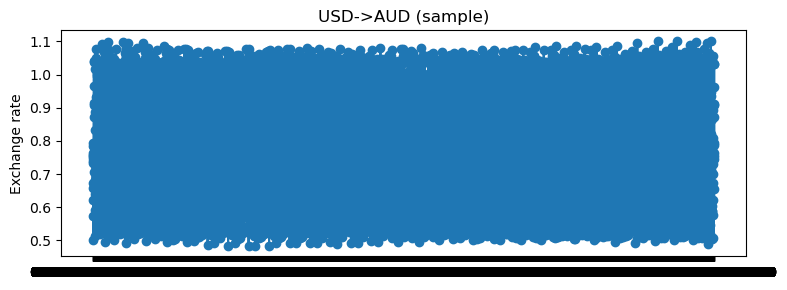

In [10]:
plt.figure(figsize=(8,3))
plt.plot(series, marker='o')
plt.title("USD->AUD (sample)")
plt.ylabel("Exchange rate")
plt.tight_layout()
plt.show()

In [11]:
series.isna().sum()

np.int64(0)

In [12]:
try:
    adf_res = adfuller(series)
    print("\nADF statistic: {:.6f}, p-value: {:.6f}".format(adf_res[0], adf_res[1]))
    if adf_res[1] > 0.05:
        print("-> ADF suggests non-stationarity (but unreliable with n=5).")
    else:
        print("-> ADF suggests stationarity (but unreliable with n=5).")
except Exception as e:
    print("ADF test could not be performed:", e)


ADF statistic: -14.438089, p-value: 0.000000
-> ADF suggests stationarity (but unreliable with n=5).



Max ACF/PACF lags allowed for this sample: 3793


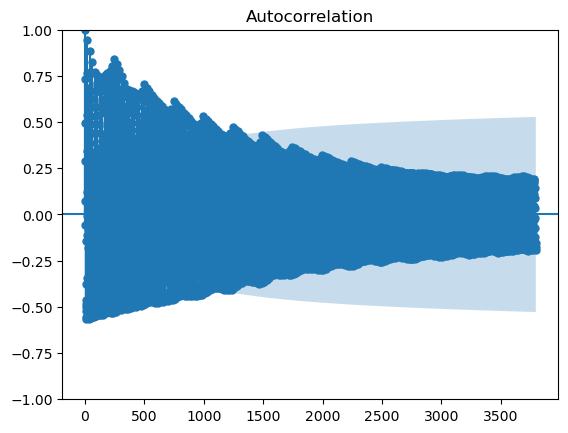

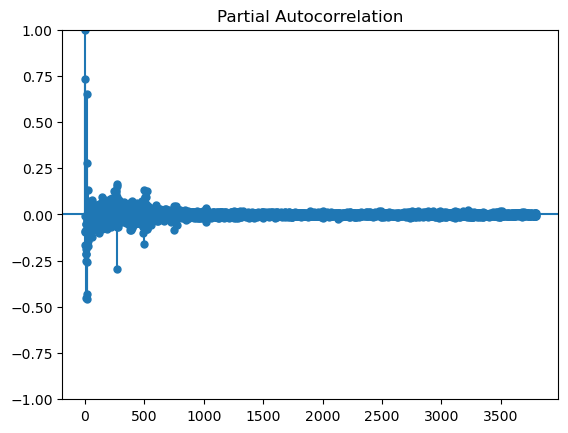

In [13]:
max_lags_allowed = max(0, len(series)//2 - 1)  
print("\nMax ACF/PACF lags allowed for this sample:", max_lags_allowed)
if max_lags_allowed >= 1:
    
    plot_acf(series, lags=max_lags_allowed)
    plt.show()
    try:
        plot_pacf(series, lags=max_lags_allowed, method='ywm')
        plt.show()
    except Exception as e:
        print("PACF plot not available:", e)
else:
    print("Not enough data to plot PACF/ACF beyond trivial lags.")

In [14]:
h = 1 if len(series) > 1 else 0
train = series[:-h] if h>0 else series.copy()
test = series[-h:] if h>0 else pd.Series(dtype=float)
print("\nTrain size:", len(train), "Test size:", len(test))


Train size: 7587 Test size: 1


In [15]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))*100 if mask.sum()>0 else np.nan

In [23]:
import warnings
warnings.filterwarnings("ignore")
arima_metrics = (np.nan, np.nan, np.nan)
if len(train) >= 3:
    best_aic = np.inf
    best_model = None
    best_order = None
    for p in range(0,3):
        for q in range(0,3):
            try:
                m = ARIMA(train, order=(p,d,q)).fit()
                if m.aic < best_aic:
                    best_aic, best_model, best_order = m.aic, m, (p,d,q)
            except Exception:
                pass
    print("\nSelected ARIMA order (illustrative):", best_order)
    if best_model is not None and h>0:
        pred = best_model.get_forecast(steps=h).predicted_mean
        pred.index = test.index
        print("ARIMA forecast (test):", pred.values)
        arima_metrics = (mean_absolute_error(test, pred),
                         sqrt(mean_squared_error(test, pred)),
                         mape(test, pred))
else:
    print("\nNot enough observations to fit ARIMA (need >=3 in this simple routine).")



Selected ARIMA order (illustrative): (1, 1, 2)
ARIMA forecast (test): [0.77615927]


In [24]:
hw_metrics = (np.nan, np.nan, np.nan)
if len(train) >= 2 and h>0:
    try:
        hw = ExponentialSmoothing(train, trend='add', seasonal=None).fit(optimized=True)
        hw_pred = hw.forecast(steps=h)
        hw_pred.index = test.index
        print("\nHolt-Winters forecast (test):", hw_pred.values)
        hw_metrics = (mean_absolute_error(test, hw_pred),
                      sqrt(mean_squared_error(test, hw_pred)),
                      mape(test, hw_pred))
    except Exception as e:
        print("Holt-Winters fitting failed:", e)
else:
    print("\nNot enough observations to fit Holt-Winters trend model (need >=2).")


Holt-Winters forecast (test): [0.79510245]


In [25]:
comp = pd.DataFrame({
    "Model": ["ARIMA", "Holt-Winters"],
    "MAE": [arima_metrics[0], hw_metrics[0]],
    "RMSE": [arima_metrics[1], hw_metrics[1]],
    "MAPE (%)": [arima_metrics[2], hw_metrics[2]]
})

In [19]:
comp.to_string(index=False)

'       Model      MAE     RMSE  MAPE (%)\n       ARIMA      NaN      NaN       NaN\nHolt-Winters 0.041721 0.041721  5.537895'

#### Part 1 — Data Preparation & Exploration

Data loading: explain parsing the date column using dayfirst=True to get proper DatetimeIndex.

Exploration: include the time plot and descriptive stats. Explicitly note “sample size = 5 — insufficient to detect seasonality or reliable trends.”

Preprocessing: mention missing-value check (none in this snippet) and general approaches you would use on a full dataset (time interpolation, forward/back-fill, outlier detection e.g. winsorizing or local median-based smoothing).

Part 2 — Model Building (ARIMA)

Parameter selection via ACF/PACF: say that with n=5 ACF/PACF beyond trivial lags are unreliable. Show the small ACF plot and state that you cannot form meaningful p/q suggestions.

Model fitting: state you attempted minimal ARIMA only for demonstration; include the code and note the fitted order is only illustrative.

Diagnostics: state that residual diagnostics are not meaningful with so few residuals. For a full dataset you would plot residuals, ACF of residuals, Ljung-Box test, QQ-plot.

Forecasting: show the illustrative forecast and explicitly label it “not robust”.

Part 3 — Evaluation & Comparison

Compute MAE/RMSE/MAPE (they will be computed if a 1-step test exists) but emphasize these are not meaningful for model comparison on n=5; explain for a real assignment you should use rolling-origin cross-validation and multiple test windows.

Discuss general comparative points: Holt–Winters good for stable seasonality + trend; ARIMA for autocorrelation structure and short-term dynamics; SARIMA for seasonal AR terms.

Conclusion

State that with only 5 observations you cannot recommend a best model. Provide clear next steps to obtain/prepare more data (below).